In [220]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [355]:
import torch
from datasets import load_dataset
from mini_yolov3.dataset import SVNHDataset, collate_fn
from mini_yolov3.utils import coco_to_xyxy_format, draw_bounding_boxes, draw_grid
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mini_yolov3.loss import build_target

In [356]:
dataset = SVNHDataset(split="train", image_size=64, normalize=True, type="tensor")

In [414]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [417]:
for x in dataloader:
    bbox = x["bbox"]
    labels = x["labels"]

    target = build_target(bbox, grid_size=13, labels=labels)

    break

cell_size 0.07692307692307693
tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]]) tensor([4, 6], dtype=torch.int8)
torch.Size([2, 4])


In [419]:
target[0][:, 5, 5]

tensor([0.4533, 0.4565, 0.1963, 0.8696, 1.0000, 4.0000])

In [380]:
target[0][:, 6, 7]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [338]:
item = dataset[0]

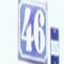

In [339]:
image = item["image"]
image

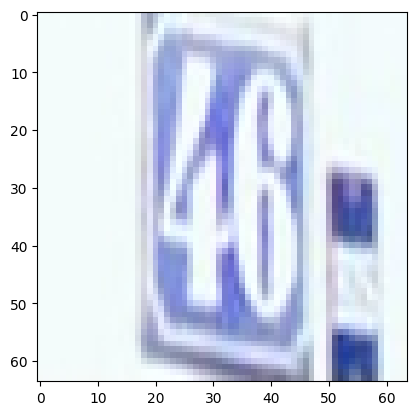

In [255]:
plt.imshow(image.permute(1, 2, 0))

In [256]:
labels = item["labels"]
labels

tensor([4, 6], dtype=torch.int8)

In [257]:
bbox = item["bbox"]
bbox

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

In [360]:
64 / 13

4.923076923076923

0
5
10
15
20
25
30
35
40
45
50
55
60


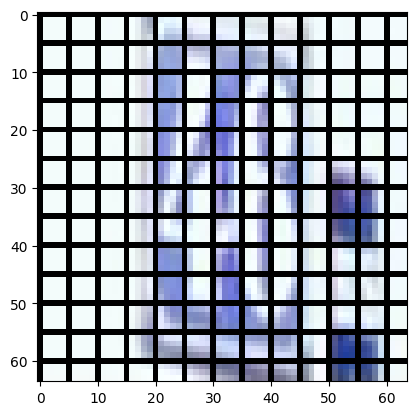

In [361]:
plt.imshow(draw_grid(image, grid_size=5))